In [1]:
from numpy import *
import astropy.units as u
from astropy.constants import G, M_jup, R_jup, M_earth, R_earth, L_sun, M_sun, R_sun
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import extinction as ex
import scipy.stats as st

In [2]:
#import scaling relation coefficients
rel = pd.read_csv('scalingrels_a17.csv')
rel.set_index('Tracer', inplace=True)

## Functions:

Cell 1: Line luminosity (additional ones in Test notebook)

Cell 2: Accretion luminosity. Has error analysis capability built in, but is not utilized right now.

Cell 3: Accretion rate

Cell 4: Get rate (run through 1, 2, and 3 sequentially)


In [3]:
def line_lum(line_flux, dist):
    """
    Calculate line luminosity given line flux and distance
    assuming line flux is extinction corrected.
    """
    #future: could add extinction correction in there? Not sure how that works.
    
    line_lum = 4 * pi * (dist*u.pc)**2 * line_flux * u.erg / (u.s * (u.cm)**2)
    line_lum = line_lum.decompose().to(u.W)
    return line_lum/u.W

In [4]:
def accr_lum(L_line, tracer, L_line_err = 0*u.W):
    """
    Translate a line luminosity to accretion luminosity using empirical
    relationships from Alcala et al. 2017.
    
    Included tracers are:
    'Ha'
    'Hb'
    'Hg'
    'PaB'
    'PaG'
    'He I 587.6'
    'He I 667.8'
    'Ca II K'
    'Ca II H'
    """
        
    a, a_err, b, b_err = rel['a'][tracer],rel['a_err'][tracer],rel['b'][tracer],rel['b_err'][tracer]
    
    log_L_acc = b + a * log10(L_line*u.W/L_sun)
    
    L_acc = 10**log_L_acc*L_sun/u.W
    
    #attempt at error propagation
    
    #c_err = (L_line_err)/(log(10) * L_line)
    #ac_err = a * log10(L_line/L_sun) * ((a_err/a)**2 + (c_err/log10(L_line/L_sun))**2)**0.5
    #log_L_acc_err = (b_err**2 + ac_err**2)**0.5
    #L_acc_err = L_acc * log(10) * log_L_acc_err

    return L_acc

In [5]:
def acc_rate(L_acc, R, M):
    """
    Translate an accretion luminosity and planet mass/radius to accretion rate in Solar masses per year.
    """
    mdot = 1.25*L_acc*u.W*R*u.R_sun/(G*M*u.M_sun)
    mdot = mdot.decompose().to(u.M_sun/u.yr)
    return(mdot/(u.M_sun/u.yr))

In [6]:
def get_rate(line_flux, d, t, R, M):
    """
    Turn a line flux into an accretion rate, 
    given the distance, tracer, object radius, and object mass.
    
    Line flux should be in erg/s/cm^2; distance in pc;
    tracer either Ha, PaB, or BrG; radius in solar radii,
    and mass in solar masses.
    """
    l_line = line_lum(line_flux,d)
    l_acc = accr_lum(l_line, t)
    mdot = acc_rate(l_acc, R, M)
    
    return mdot

### Recalculate accretion rates for Ha, PaB, and BrG tracers

Using new distances but old masses

In [7]:
db = pd.read_csv('recalculations.csv')
tracers = ['Ha','PaB','BrG']

In [8]:
for i in db.index:
    
    #use new distance if it's available
    #else, use arbitrary distance
    #(some are legitimately pulled from papers but other just assume 140)
    d = db.loc[i,'Plx Distance']
    if isnan(d):
        d = db.loc[i,'Object Distance']
    
    R = db.loc[i,'Object Radius']
    M = db.loc[i,'Object Mass, Original']
    
    #ignore if missing M or R
    if (isnan(M) or isnan(R)):
        continue
        
    for t in tracers:
        lf = db.loc[i,t + ' Line Flux']
        
        if isnan(lf)==False:
            
            #extinction correction for N06 fluxes
            if db.loc[i,'Reference']=='Natta 2006':
                lf = ex.remove(db.loc[i,'A_J'],lf)
            
            #get the accretion rate
            db.at[i,t + ' Accr Rate'] = get_rate(lf, d, t, R, M)

In [9]:
#take average accretion rate across the three tracers
db['Avg Accr Rate'] = db[[t + ' Accr Rate' for t in tracers]].mean(axis=1)

Now, switch to plotting and analysis

In [10]:
#Take relevant columns and drop NaNs
aa = db[['Source','Reference','Object Mass, Original', 'Avg Accr Rate','Old Accr Rate']].dropna()

In [11]:
#lists of mass, old accr rate, and new accr rate
m = log10(aa['Object Mass, Original'].tolist())
md_old = log10(aa['Old Accr Rate'].tolist())
md_new = log10(aa['Avg Accr Rate'].tolist())

In [12]:
sl_old, incpt_old = polyfit(m,md_old,1)
sl_new, incpt_new = polyfit(m,md_new,1)
print('Old Best-Fit: y = ', sl_old,'x ', incpt_old)
print('New Best-Fit: y = ', sl_new,'x ', incpt_new)

Old Best-Fit: y =  1.899846831907342 x  -8.074343121556483
New Best-Fit: y =  1.6568870656436852 x  -8.232150505914678


In [13]:
#correlations
r_old = st.pearsonr(m,md_old)
r_new = st.pearsonr(m,md_new)
print('Old r:', r_old)
print('New r:', r_new)

Old r: (0.6965395310641277, 1.227722316734204e-29)
New r: (0.6645662238831888, 3.235176929442843e-26)


In [14]:
print('Number of points included:', len(aa))

Number of points included: 195


Text(0, 0.5, 'log $\\dot M$  $(M_{\\odot}/yr)$')

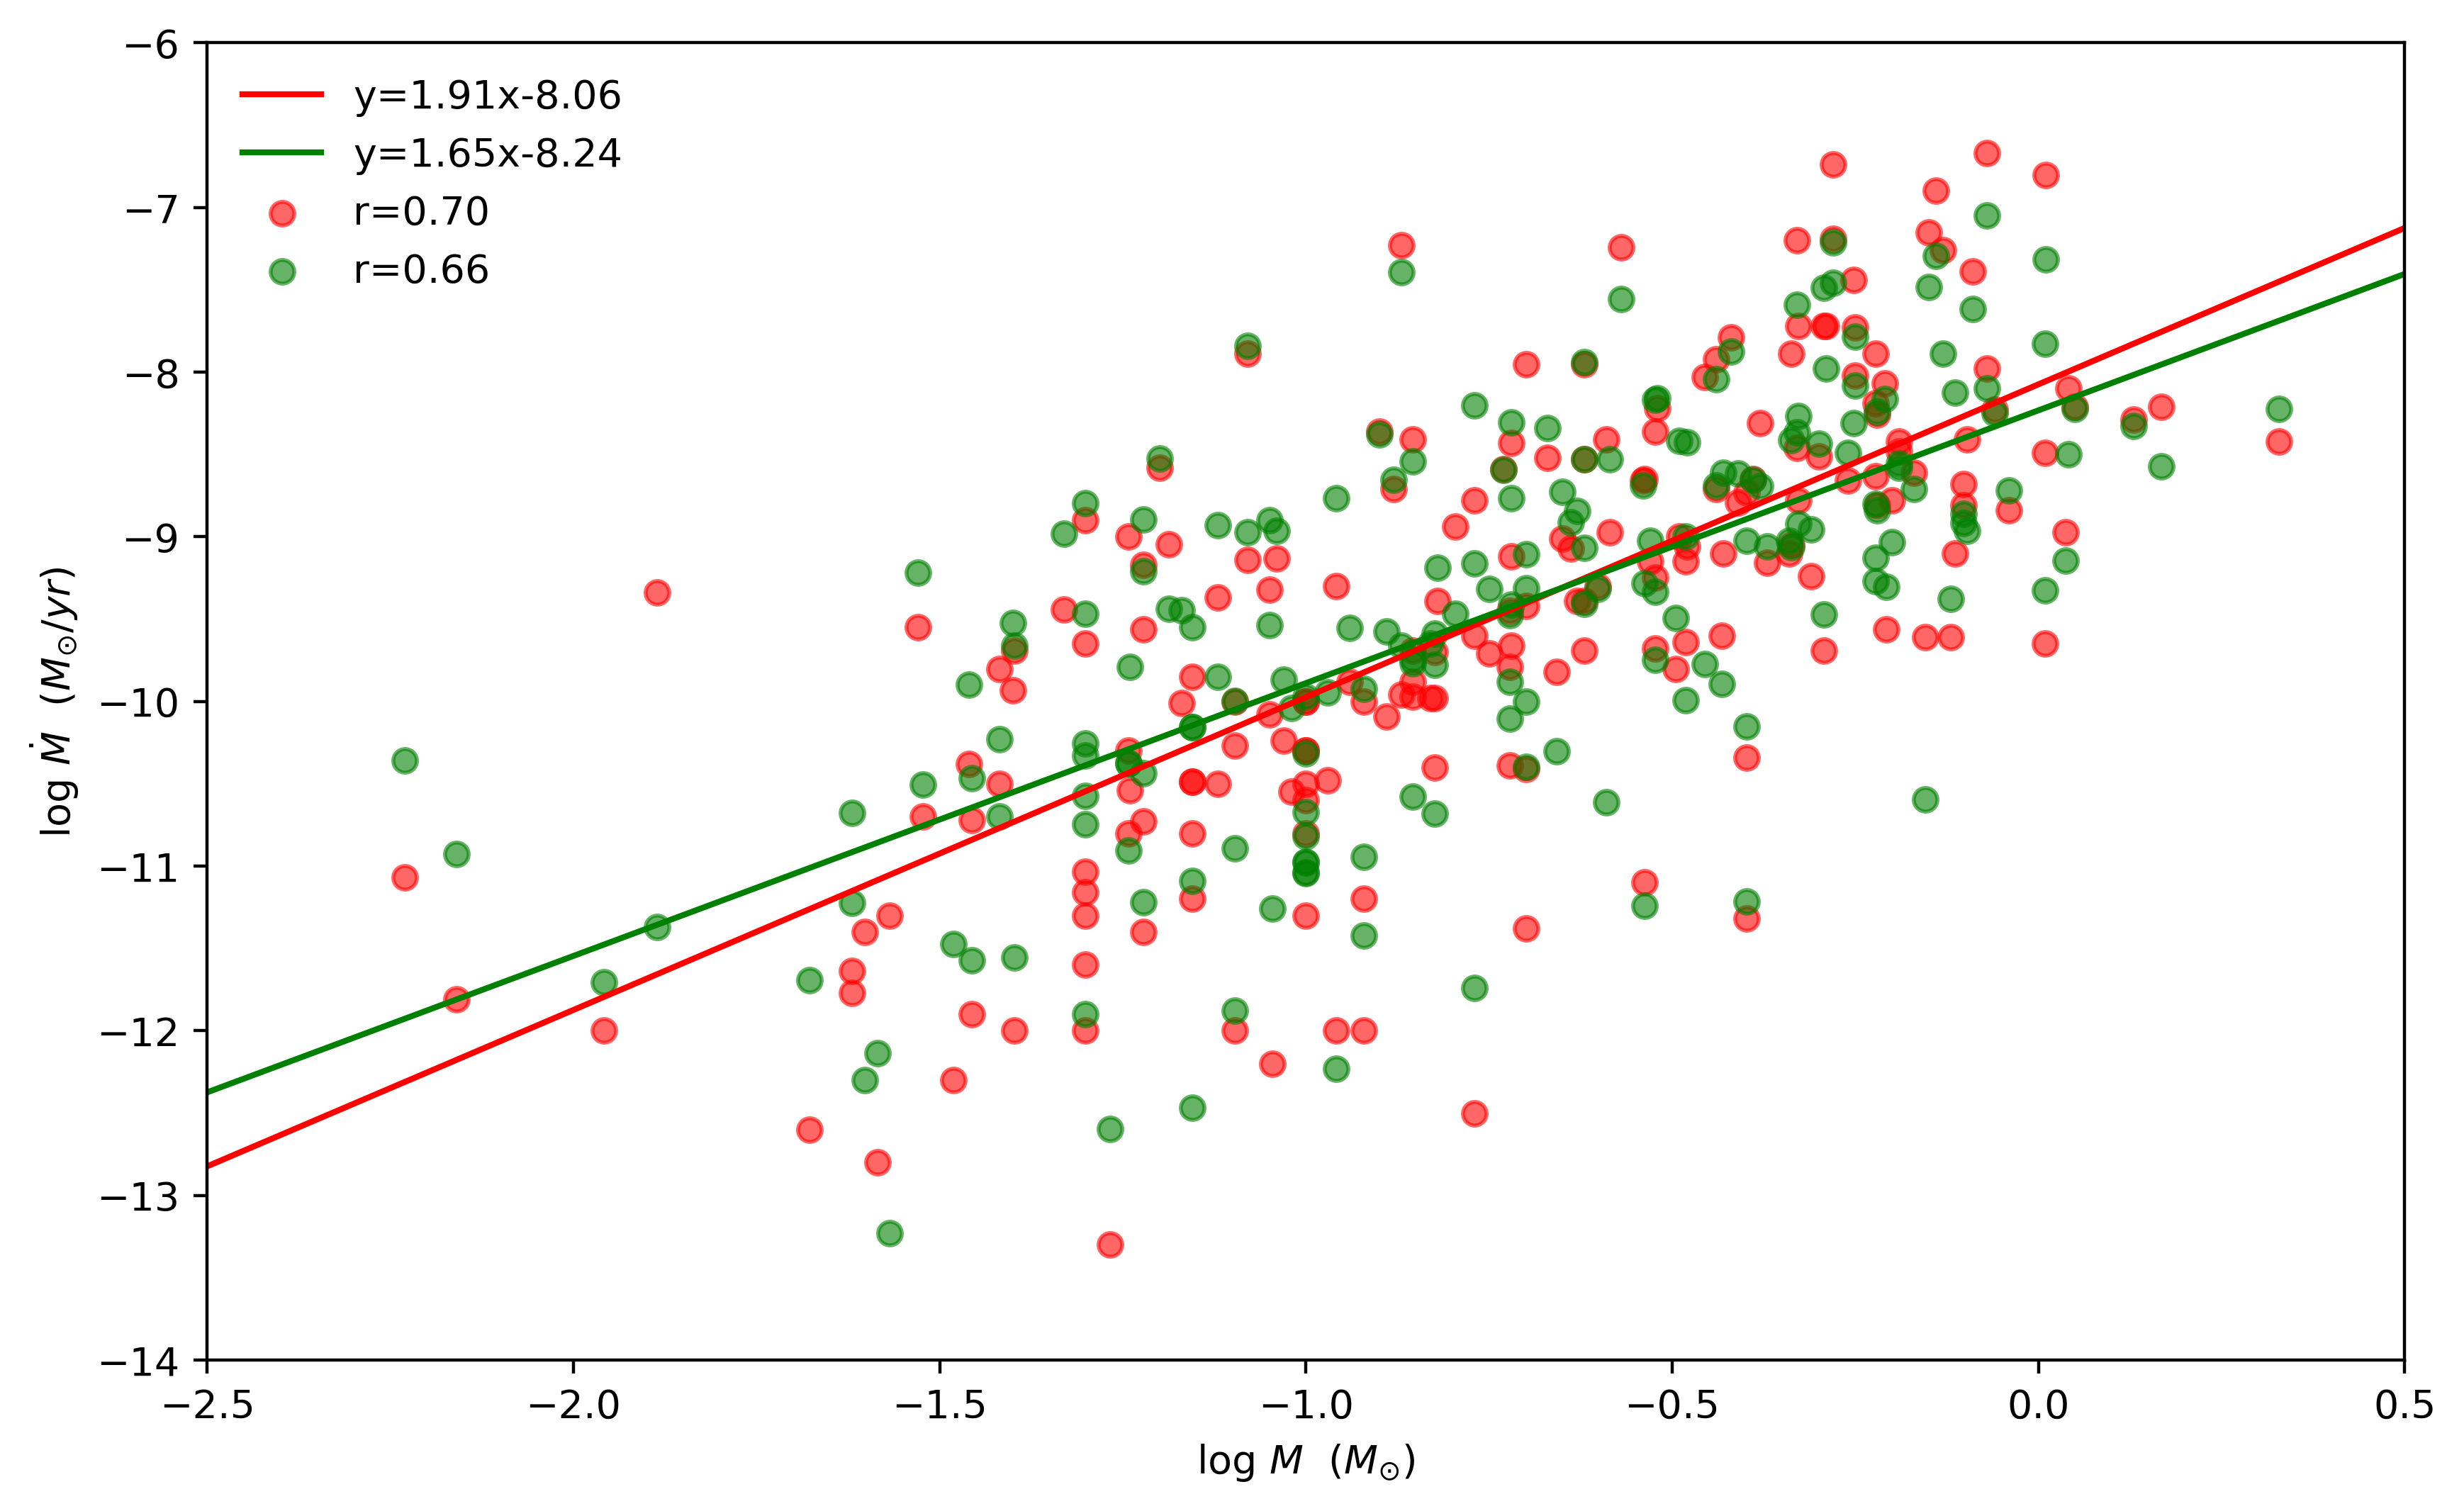

In [15]:
plt.figure(figsize=(10,10/1.625),dpi=400)

plt.scatter(m,md_old,color='r',alpha=0.6,label='r=0.70')
plt.scatter(m,md_new,color='g',alpha=0.6,label='r=0.66')

x = arange(-2.5,1,0.5)
plt.xlim(-2.5,0.5)
plt.ylim(-14,-6)

plt.plot(x, sl_old*x+incpt_old, color='r', label='y=1.91x-8.06')
plt.plot(x, sl_new*x+incpt_new, color='g', label='y=1.65x-8.24')

plt.legend(frameon=False)

plt.xlabel('log $M$  $(M_{\odot})$')
plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

Above: Plot of $M$ vs $\dot M$ for originally estimated accretion rates (red) and new estimates (green). New estimates are averages of those obtained by Ha, PaB, and BrG tracers. The best-fit line for each population is overplotted in its respective color.

Notice the correlation decreases slightly for the new estimates; this may be due to the lack of mass updates. Let's find out.

## Recalculate accretion rates: new masses!

Note that I am still using old radii

In [16]:
db2 = pd.read_csv('recalculations.csv')

In [17]:
#get accretion rates

#mass_used: one list of which mass is used to recalculate accretion rate
mass_used = []

for i in db2.index:
    
    #use new distance if it's available
    #else, use arbitrary distance
    #(some are legitimately pulled from papers but other just assume 140)
    
    d = db2.loc[i,'Plx Distance']
    if isnan(d):
        d = db2.loc[i,'Object Distance']
    
    R = db2.loc[i,'Object Radius']
    
    M = db2.loc[i,'New Mass']
    if isnan(M):
        M = db2.loc[i,'Object Mass, Original']
        
    mass_used.append(M)

    #ignore if missing M or R
    if (isnan(M) or isnan(R)):
        continue
            
    for t in tracers:
        lf = db2.loc[i,t + ' Line Flux']
        
        if isnan(lf)==False:
            
            #extinction correction for N06 fluxes
            if db2.loc[i,'Reference']=='Natta 2006':
                lf = ex.remove(db2.loc[i,'A_J'],lf)
            
            #get the accretion rate
            db2.at[i,t + ' Accr Rate'] = get_rate(lf, d, t, R, M)

In [18]:
db2['mass_used'] = mass_used

In [19]:
db2['Avg Accr Rate'] = db2[[t + ' Accr Rate' for t in tracers]].mean(axis=1)

In [20]:
#Take relevant columns and drop NaNs
aa2 = db2[['Source','Reference','Object Mass, Original','mass_used',
           'Avg Accr Rate','Old Accr Rate']].dropna()

In [21]:
#lists of mass, old accr rate, and new accr rate
m_old = log10(aa2['Object Mass, Original'].tolist())
m_new = log10(aa2['mass_used'].tolist())
md_old2 = log10(aa2['Old Accr Rate'].tolist())
md_new2 = log10(aa2['Avg Accr Rate'].tolist())

In [22]:
sl_old2, incpt_old2 = polyfit(m_old,md_old2,1)
sl_new2, incpt_new2 = polyfit(m_new,md_new2,1)
print('Old Best-Fit: y = ', sl_old2,'x ', incpt_old2)
print('New Best-Fit: y = ', sl_new2,'x ', incpt_new2)

Old Best-Fit: y =  1.899846831907342 x  -8.074343121556483
New Best-Fit: y =  1.672825096291903 x  -8.223327444034178


In [23]:
#correlations
r_old2 = st.pearsonr(m_old,md_old2)
r_new2 = st.pearsonr(m_new,md_new2)
print('Old r:', r_old2)
print('New r:', r_new2)

Old r: (0.6965395310641277, 1.227722316734204e-29)
New r: (0.6471078661884397, 1.6058727888306672e-24)


In [24]:
print('Number of points included:', len(aa2))

Number of points included: 195


Text(0, 0.5, 'log $\\dot M$  $(M_{\\odot}/yr)$')

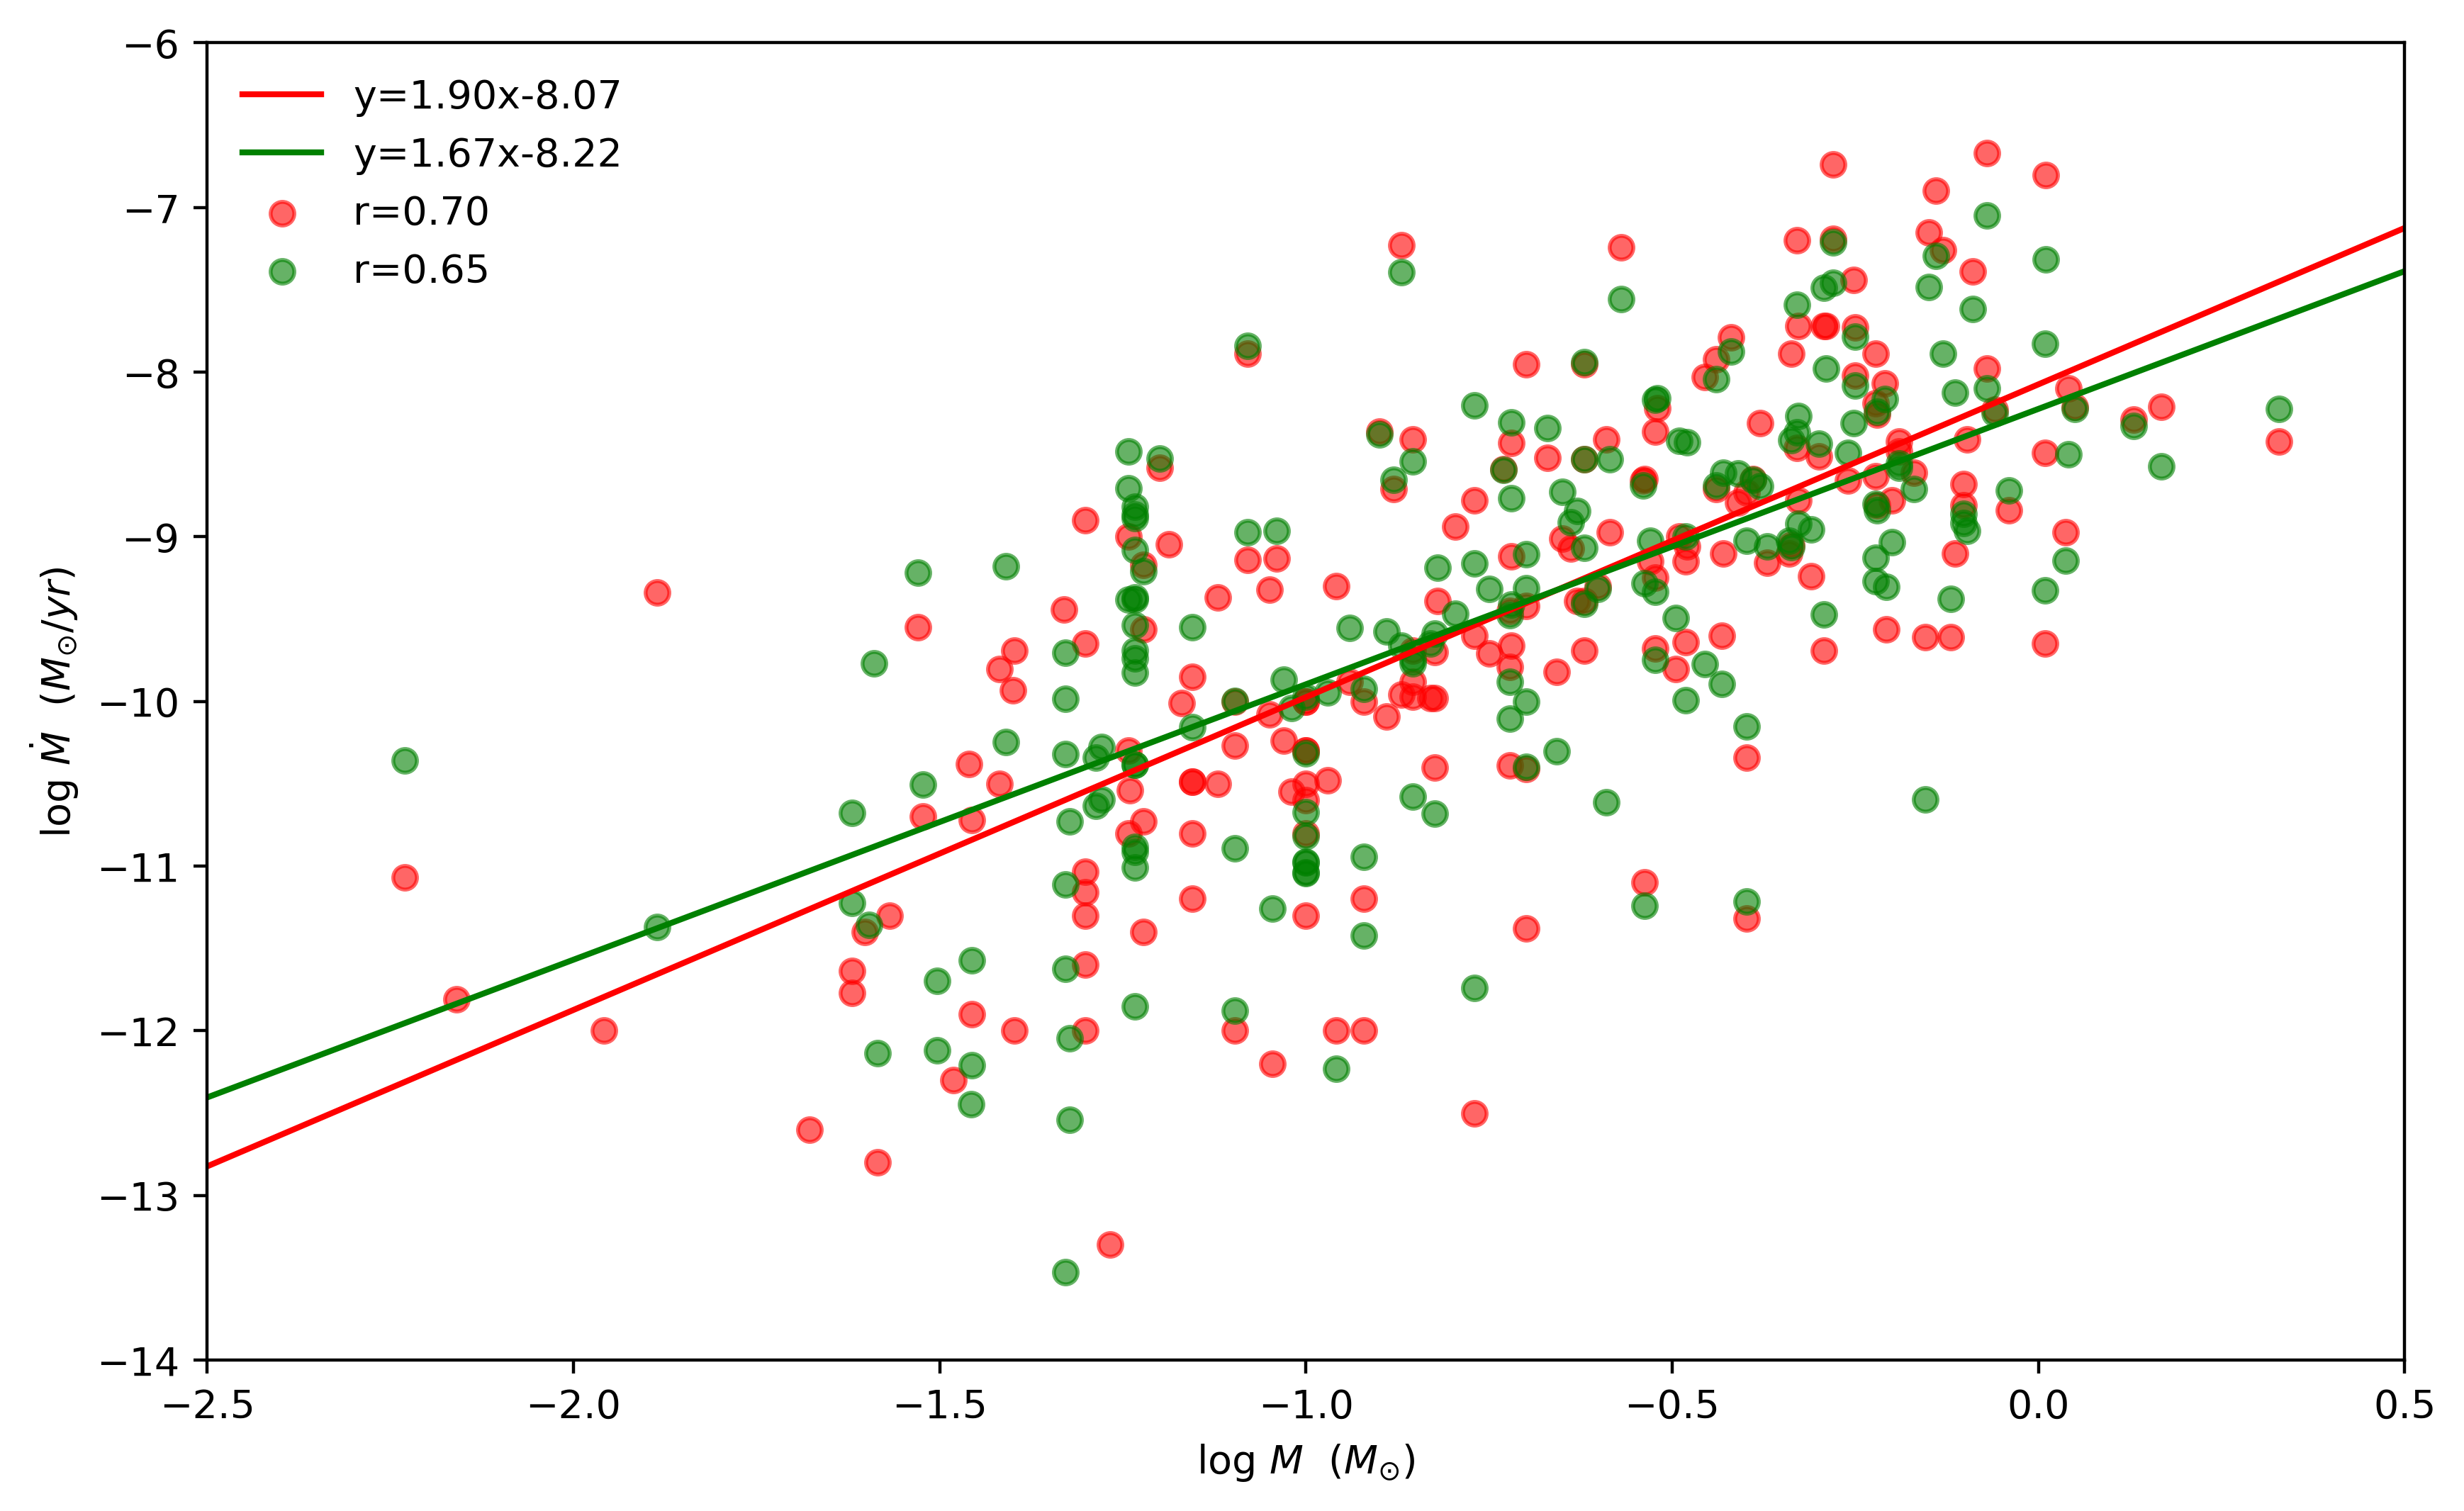

In [25]:
plt.figure(figsize=(10,10/1.625),dpi=400)

plt.scatter(m_old,md_old2,color='r',alpha=0.6,label='r=0.70')
plt.scatter(m_new,md_new2,color='g',alpha=0.6,label='r=0.65')

x = arange(-2.5,1,0.5)
plt.xlim(-2.5,0.5)
plt.ylim(-14,-6)

plt.plot(x, sl_old2*x+incpt_old2, color='r', label='y=1.90x-8.07')
plt.plot(x, sl_new2*x+incpt_new2, color='g', label='y=1.67x-8.22')

plt.legend(frameon=False)

plt.xlabel('log $M$  $(M_{\odot})$')
plt.ylabel('log $\dot M$  $(M_{\odot}/yr)$')

Hmm, the correlation is still slightly lower.